# PyTorch scaling benchmark analysis

Throughput scaling of PyTorch benchmarks on Cori Haswell with PyTorch distributed and Cray MPI.

In [1]:
import os
import re
import glob

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Utilities

In [4]:
def plot_scaling(ranks, rates, title=None, loglog=False):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of workers')
    ax0.set_ylabel('Training throughput [samples/s]')
    if loglog:
        ax0.set_xscale('log')
        ax0.set_yscale('log')
    else:
        ax0.set_ylim(bottom=0)
    ax0.grid()
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.plot(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of workers')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(bottom=0)
    
    if title is not None:
        ax0.set_title(title)
        ax1.set_title(title)

    plt.tight_layout()
    return fig, ax0, ax1

## Load the results data

In [5]:
ls /global/cscratch1/sd/sfarrell/pytorch-benchmarks/results

gpu-1.7.0-gloo-n1/   gpu-1.7.0-gloo-n8/   gpu-1.7.0-nccl-n64/
gpu-1.7.0-gloo-n16/  gpu-1.7.0-nccl-n1/   gpu-1.7.0-nccl-n8/
gpu-1.7.0-gloo-n2/   gpu-1.7.0-nccl-n16/  gpu-ngc-20.08-v0-nccl-n1/
gpu-1.7.0-gloo-n32/  gpu-1.7.0-nccl-n2/   gpu-ngc-20.09-v0-nccl-n1/
gpu-1.7.0-gloo-n4/   gpu-1.7.0-nccl-n32/  gpu-ngc-20.10-v0-nccl-n1/
gpu-1.7.0-gloo-n64/  gpu-1.7.0-nccl-n4/


In [9]:
results_files = glob.glob('/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n*/results.txt')

results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n64/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n4/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n8/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n2/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n32/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/results/gpu-1.7.0-gloo-n16/results.txt']

In [10]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,backend,model
0,145752.504712,876345.306107,64,gpu,1.7.0,gloo,lstm
1,13416.306739,140485.612480,64,gpu,1.7.0,gloo,alexnet
2,15165.722561,53695.186352,64,gpu,1.7.0,gloo,resnet50
3,132746.800399,527208.624703,64,gpu,1.7.0,gloo,cnn3d
4,20048.171582,54954.547700,4,gpu,1.7.0,gloo,lstm
5,1242.245492,10093.703630,4,gpu,1.7.0,gloo,alexnet
6,1164.866554,3568.095960,4,gpu,1.7.0,gloo,resnet50
7,12204.357367,32804.728362,4,gpu,1.7.0,gloo,cnn3d
8,35217.914992,110462.650221,8,gpu,1.7.0,gloo,lstm
9,2108.815275,17525.163031,8,gpu,1.7.0,gloo,alexnet


## Training throughput scaling

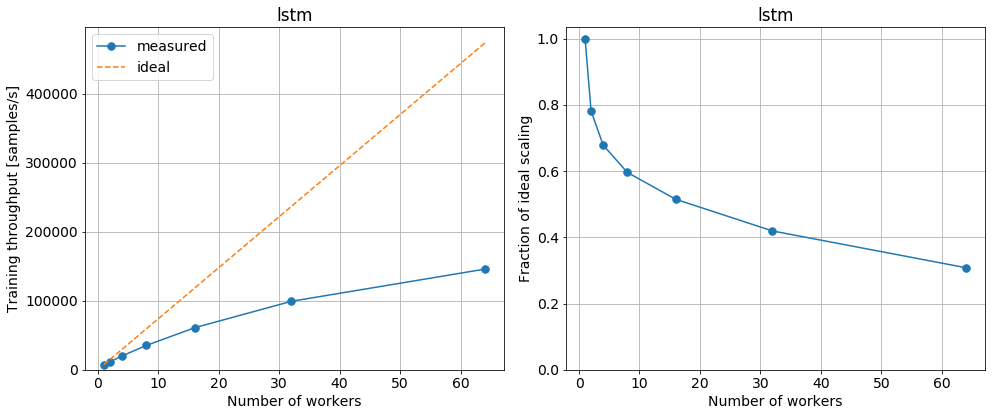

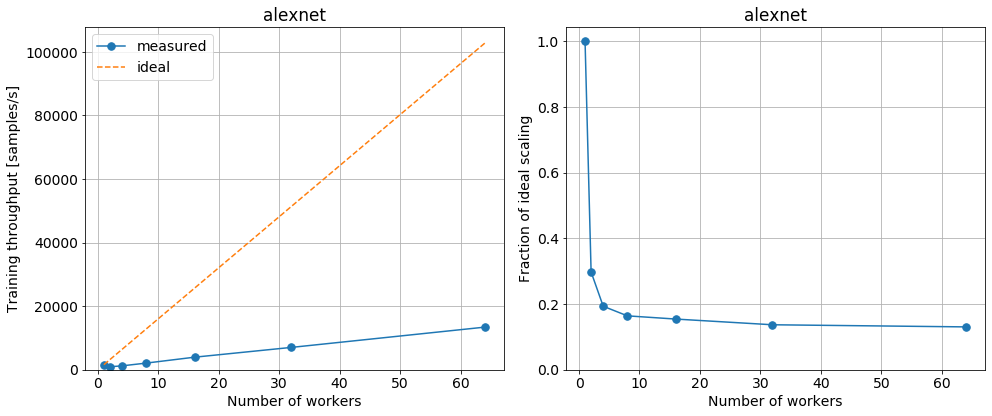

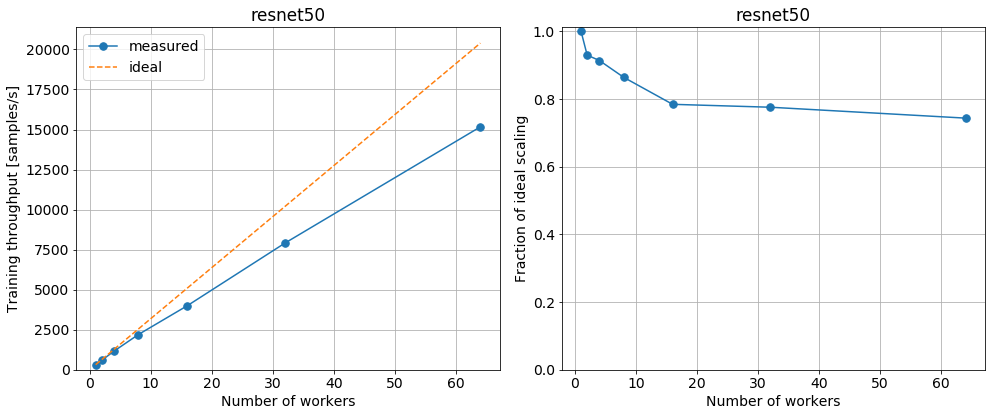

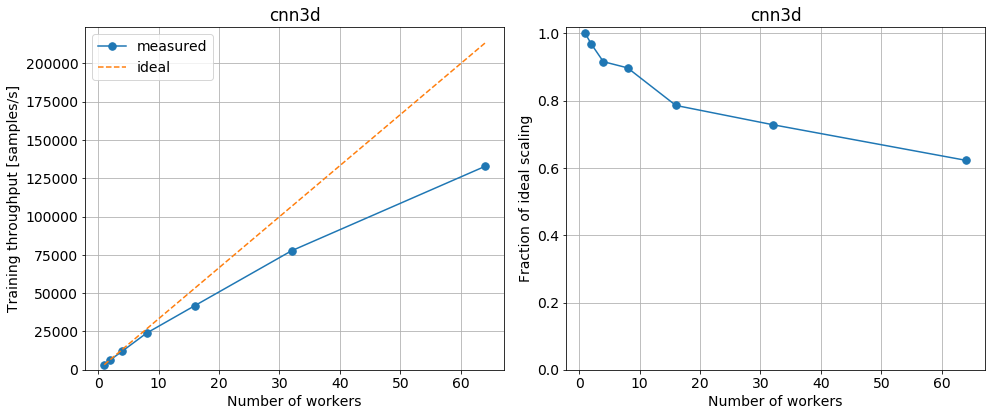

In [11]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.train_rate.values,
                                 title=model)

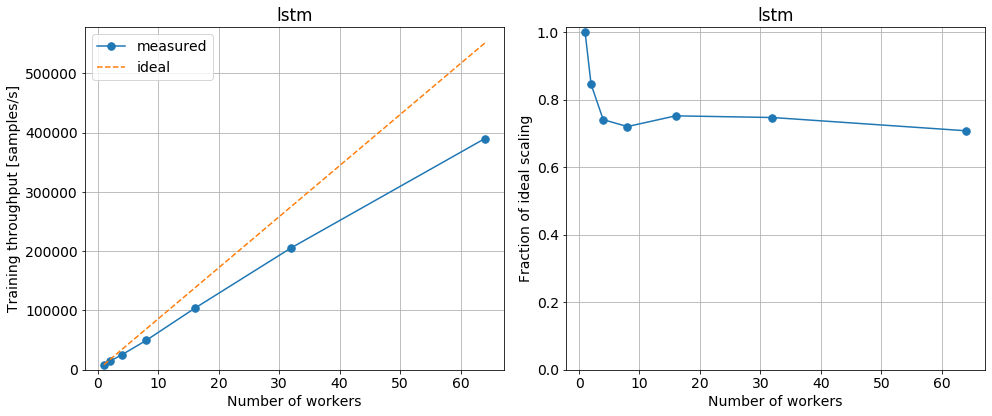

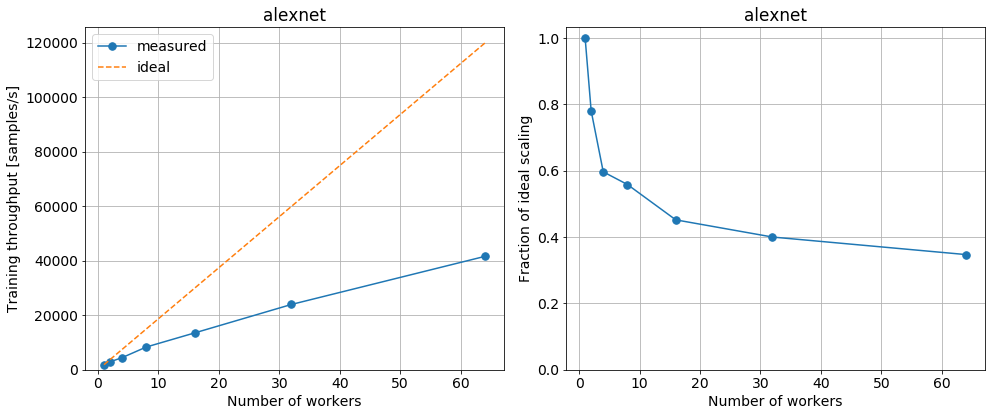

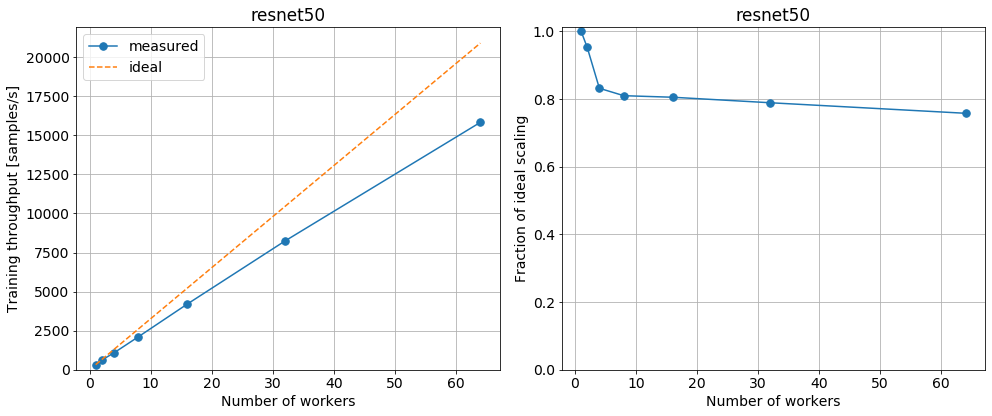

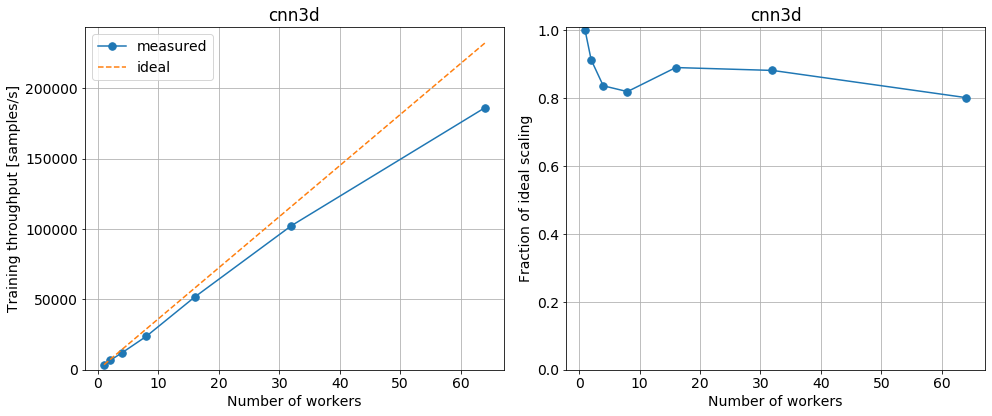

In [8]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.train_rate.values,
                                 title=model)

## Inference throughput scaling

In [ ]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.inference_rate.values,
                                 title=model)